In [2]:
from src.collocation import CollocationSchrodinger
from src.pinn import PINN, train_pinn
from src.differential import SchrodingerDifferential
import numpy as np
import torch

In [ ]:
# Define hyperparameters
input_dim = 2  # tau and S
hidden_dim = 100
output_dim = 2  # real part, complex part
num_hidden_layers = 4
num_epochs = 20000
learning_rate = 0.001
activation_fn = 'tanh'

# Instantiate model and collocation generator
model = PINN(input_dim, hidden_dim, output_dim, num_hidden_layers, activation_fn, lb = (0.0, -5.0), ub = (np.pi/2, 5.0))
collocation = CollocationSchrodinger(t_max=np.pi/2, x_min=-5, x_max=5, n_collocation=2000, n_boundary=200)
differential = SchrodingerDifferential()

optimizer_lbfgs = torch.optim.LBFGS(
    model.parameters(),
    lr=1.0,
    max_iter=50000,
    max_eval=50000,
    history_size=50,
    line_search_fn='strong_wolfe',
    tolerance_change=np.finfo(float).eps,
    tolerance_grad=1e-9
)


trained_model = train_pinn(
    model=model,
    collocation=collocation,
    differential=differential,
    num_epochs=num_epochs,
    learning_rate=learning_rate,
    gamma = 0.9,
    optimizer_lbfgs = optimizer_lbfgs
)

Epoch 100/20000, PDE Loss: 0.021120, Boundary Loss: 0.053356, Total Loss: 0.074476
Epoch 200/20000, PDE Loss: 0.014064, Boundary Loss: 0.031627, Total Loss: 0.045691
Epoch 300/20000, PDE Loss: 0.019671, Boundary Loss: 0.022410, Total Loss: 0.042081
Epoch 400/20000, PDE Loss: 0.013803, Boundary Loss: 0.017198, Total Loss: 0.031002
Epoch 500/20000, PDE Loss: 0.013956, Boundary Loss: 0.012961, Total Loss: 0.026918
Epoch 600/20000, PDE Loss: 0.014258, Boundary Loss: 0.011252, Total Loss: 0.025510
Epoch 700/20000, PDE Loss: 0.015972, Boundary Loss: 0.010654, Total Loss: 0.026626
Epoch 800/20000, PDE Loss: 0.013719, Boundary Loss: 0.010183, Total Loss: 0.023903
Epoch 900/20000, PDE Loss: 0.011605, Boundary Loss: 0.010774, Total Loss: 0.022378
Epoch 1000/20000, PDE Loss: 0.009289, Boundary Loss: 0.014837, Total Loss: 0.024127
Epoch 1100/20000, PDE Loss: 0.008708, Boundary Loss: 0.008893, Total Loss: 0.017602
Epoch 1200/20000, PDE Loss: 0.011170, Boundary Loss: 0.007346, Total Loss: 0.018517
E

In [3]:
import scipy.io

In [4]:
import numpy as np

In [5]:
data = scipy.io.loadmat('NLS.mat')

In [6]:
t = data['tt'].flatten()[:, None]  # shape (T, 1)
x = data['x'].flatten()[:, None]   # shape (X, 1)
Exact = data['uu']   

In [7]:
Exact_u = np.real(Exact)
Exact_v = np.imag(Exact)
Exact_h = np.sqrt(Exact_u**2 + Exact_v**2)

In [8]:
X_grid, T_grid = np.meshgrid(x, t)
X_star = np.hstack((T_grid.flatten()[:, None], X_grid.flatten()[:, None]))

In [9]:
u_star = Exact_u.T.flatten()[:, None]
v_star = Exact_v.T.flatten()[:, None]
h_star = Exact_h.T.flatten()[:, None]

In [10]:
import torch

# Convert test points to tensor (ensure same device as model)
X_star_tensor = torch.tensor(X_star, dtype=torch.float32)

# Evaluate your trained PINN model
with torch.no_grad():
    pinn_pred = model(X_star_tensor).cpu().numpy()

u_pred = pinn_pred[:, 0:1]
v_pred = pinn_pred[:, 1:2]
h_pred = np.sqrt(u_pred**2 + v_pred**2)

In [11]:
error_u = np.linalg.norm(u_star - u_pred, 2) / np.linalg.norm(u_star, 2)
error_v = np.linalg.norm(v_star - v_pred, 2) / np.linalg.norm(v_star, 2)
error_h = np.linalg.norm(h_star - h_pred, 2) / np.linalg.norm(h_star, 2)

print('Relative L2 Error (u): {:.2e}'.format(error_u))
print('Relative L2 Error (v): {:.2e}'.format(error_v))
print('Relative L2 Error (|h|): {:.2e}'.format(error_h))

Relative L2 Error (u): 1.16e-01
Relative L2 Error (v): 1.94e-01
Relative L2 Error (|h|): 2.66e-02


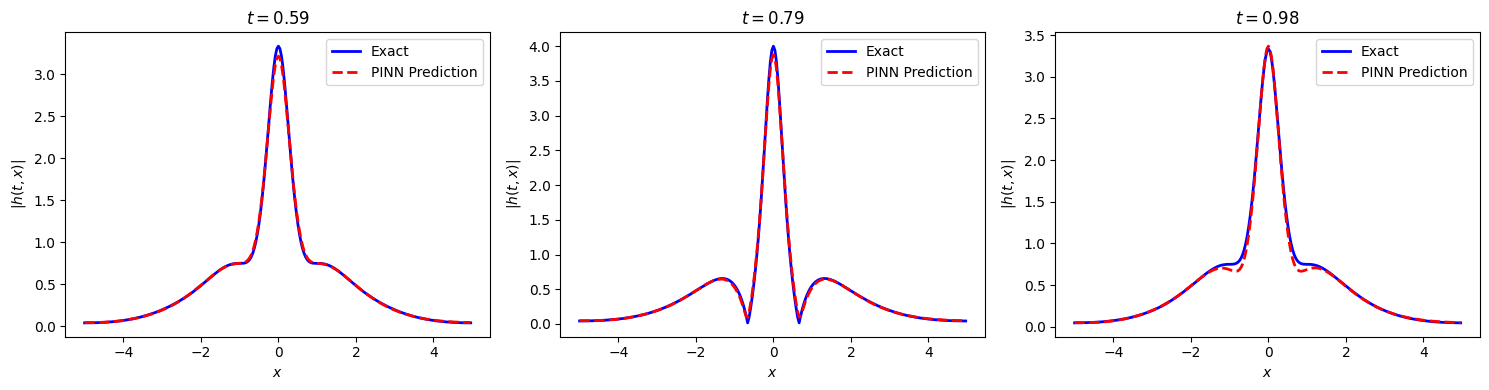

In [12]:
import matplotlib.pyplot as plt

# Reshape predicted solutions to original grid shape
U_pred = u_pred.reshape(len(t), len(x))
V_pred = v_pred.reshape(len(t), len(x))
H_pred = h_pred.reshape(len(t), len(x))

# Visual comparison at specific times (indices from original paper)
time_indices = [75, 100, 125]  # Example indices (adjust if needed)

plt.figure(figsize=(15,4))

for i, idx in enumerate(time_indices):
    plt.subplot(1, 3, i+1)
    plt.plot(x, Exact_h[:, idx], 'b-', linewidth=2, label='Exact')
    plt.plot(x, H_pred[idx, :], 'r--', linewidth=2, label='PINN Prediction')
    plt.xlabel('$x$')
    plt.ylabel('$|h(t,x)|$')
    plt.title(f'$t = {t[idx][0]:.2f}$')
    plt.legend()

plt.tight_layout()
plt.show()
